## Import package

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from tqdm import tqdm, trange
from multiprocessing import Pool, cpu_count
from functools import partial
from sklearn.metrics import mean_absolute_error

## Reading data

In [2]:
df = pd.read_csv("train.csv")
test = pd.read_csv("example_test_files/test.csv")
df.shape

(5237980, 17)

In [3]:
test_target = df[df["date_id"]>=478].reset_index(drop=True)#==test
# test_target = test_target["target"]
test_target

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,478,0,3753451.43,-1,0.999875,11548975.43,NaN,NaN,0.999875,22940.00,1.000050,9177.60,1.000000,-5.429983,26290,478_0_0
1,1,478,0,985977.11,-1,1.000245,3850033.97,NaN,NaN,0.999940,1967.90,1.000601,19692.00,1.000000,-1.869798,26290,478_0_1
2,2,478,0,599128.74,1,1.000584,4359198.25,NaN,NaN,0.999918,4488.22,1.000636,34955.12,1.000000,-0.090003,26290,478_0_2
3,3,478,0,2872317.54,-1,0.999802,27129551.64,NaN,NaN,0.999705,16082.04,1.000189,10314.00,1.000000,-7.609725,26290,478_0_3
4,4,478,0,740059.14,-1,0.999886,8880890.78,NaN,NaN,0.999720,19012.35,1.000107,7245.60,1.000000,-3.290176,26290,478_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32995,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
32996,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
32997,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
32998,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


In [4]:
# df.describe()
check = df[(df["seconds_in_bucket"] <= 300)]
check.isna().sum(), check.shape

(stock_id                         0
 date_id                          0
 seconds_in_bucket                0
 imbalance_size                 124
 imbalance_buy_sell_flag          0
 reference_price                124
 matched_size                   124
 far_price                  2861365
 near_price                 2857084
 bid_price                      124
 bid_size                         0
 ask_price                      124
 ask_size                         0
 wap                            124
 target                          63
 time_id                          0
 row_id                           0
 dtype: int64,
 (2952316, 17))

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   object 
dtypes: float64(11), int64(5), object(1)
memory usage: 679.4+ MB


## Feature having NA value

seconds in bucket >= 300 後才開始有 far price 跟 near price

In [6]:
isna_var = df.isna().sum()
na_var = isna_var[isna_var!=0]
na_col = na_var.index
print(na_var)

imbalance_size         220
reference_price        220
matched_size           220
far_price          2894342
near_price         2857180
bid_price              220
ask_price              220
wap                    220
target                  88
dtype: int64


imbalance_size, reference_price, matched_size, bid_price, ask_price, wap的220筆遺失值都是同樣的樣本資料

In [7]:
stock = sorted(df[np.isnan(df["wap"])]["stock_id"].unique())
stock

[19, 101, 131, 158]

stock id 為19, 101, 131, 158有遺失值

In [8]:
na_date = []
for n in stock:
    na_date.append(df[np.isnan(df["wap"]) & (df["stock_id"]==n)]["date_id"].unique()[0])

na_date

[438, 328, 35, 388]

stock id 為 19 且 date id 為 438 有遺失值； \
stock id 為 101 且 date id 為 328 有遺失值； \
stock id 為 131 且 date id 為 35 有遺失值； \
stock id 為 158 且 date id 為 388 有遺失值； \
target也是在相同的股票id與天數id有遺失值

In [9]:
na_target = sorted(df[np.isnan(df["target"])]["stock_id"].unique())
# df[np.isnan(df["target"]) & np.isnan(df["wap"])].sort_values(by="stock_id")
na_target, [df[np.isnan(df["target"]) & (df["stock_id"]==id)]["date_id"].unique()[0] for id in na_target]

([19, 101, 131, 158], [438, 328, 35, 388])

刪除220筆NaN資料

In [10]:
df = df[~np.isnan(df["reference_price"])]
df.shape

(5237760, 17)

In [11]:
df.isna().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                   0
imbalance_buy_sell_flag          0
reference_price                  0
matched_size                     0
far_price                  2894122
near_price                 2856960
bid_price                        0
bid_size                         0
ask_price                        0
ask_size                         0
wap                              0
target                           0
time_id                          0
row_id                           0
dtype: int64

In [12]:
# df.describe()
check = df[(df["seconds_in_bucket"] >= 300)]
check.isna().sum()

stock_id                       0
date_id                        0
seconds_in_bucket              0
imbalance_size                 0
imbalance_buy_sell_flag        0
reference_price                0
matched_size                   0
far_price                  37162
near_price                     0
bid_price                      0
bid_size                       0
ask_price                      0
ask_size                       0
wap                            0
target                         0
time_id                        0
row_id                         0
dtype: int64

In [13]:
df.describe()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
count,5.237760e+06,5.237760e+06,5.237760e+06,5.237760e+06,5.237760e+06,5.237760e+06,5.237760e+06,2.343638e+06,2.380800e+06,5.237760e+06,5.237760e+06,5.237760e+06,5.237760e+06,5.237760e+06,5.237760e+06,5.237760e+06
mean,9.928843e+01,2.415077e+02,2.700000e+02,5.715293e+06,-1.188886e-02,9.999955e-01,4.510025e+07,1.001713e+00,9.996601e-01,9.997263e-01,5.181414e+04,1.000264e+00,5.357708e+04,9.999920e-01,-4.758886e-02,1.330992e+04
std,5.787198e+01,1.385306e+02,1.587451e+02,2.051591e+07,8.853486e-01,2.532497e-03,1.398413e+08,7.214705e-01,1.216920e-02,2.499345e-03,1.114229e+05,2.510042e-03,1.293578e+05,2.497509e-03,9.452816e+00,7.619201e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,9.352850e-01,4.316610e+03,7.700000e-05,7.869880e-01,9.349150e-01,5.600000e-01,9.398270e-01,5.900000e-01,9.380080e-01,-3.852898e+02,0.000000e+00
25%,4.900000e+01,1.220000e+02,1.300000e+02,8.453415e+04,-1.000000e+00,9.987630e-01,5.279575e+06,9.963320e-01,9.971000e-01,9.985290e-01,7.375125e+03,9.990290e-01,7.824000e+03,9.987810e-01,-4.559755e+00,6.729000e+03
50%,9.900000e+01,2.420000e+02,2.700000e+02,1.113604e+06,0.000000e+00,9.999670e-01,1.288264e+07,9.998830e-01,9.998890e-01,9.997280e-01,2.196936e+04,1.000207e+00,2.301875e+04,9.999970e-01,-6.020069e-02,1.334500e+04
75%,1.490000e+02,3.610000e+02,4.100000e+02,4.190951e+06,1.000000e+00,1.001174e+00,3.270013e+07,1.003318e+00,1.002590e+00,1.000905e+00,5.583088e+04,1.001414e+00,5.787920e+04,1.001149e+00,4.409552e+00,1.990700e+04
max,1.990000e+02,4.800000e+02,5.400000e+02,2.982028e+09,1.000000e+00,1.077488e+00,7.713682e+09,4.379531e+02,1.309732e+00,1.077488e+00,3.028784e+07,1.077836e+00,5.440500e+07,1.077675e+00,4.460704e+02,2.645400e+04


收盤前五分鐘除了stock_id=83沒有遺失值外，其餘皆有遺失值；且僅在date_id=25, 33沒有遺失值。

In [14]:
a = sorted(df[np.isnan(df["far_price"])&(df["seconds_in_bucket"]>=300)]["stock_id"].unique())
for i in list(range(200)):
    if i not in a:
        print('stock:'+str(i))

b = sorted(df[np.isnan(df["far_price"])&(df["seconds_in_bucket"]>=300)&(df["stock_id"]!=83)]["date_id"].unique())
for i in list(range(481)):
    if i not in b:
        print('date:'+str(i))


stock:83
date:25
date:33


In [15]:
# df[(df["seconds_in_bucket"]>=300)&(df["stock_id"]==197)&np.isnan(df["far_price"])]["date_id"].unique()
df[(df["seconds_in_bucket"]>=300)&(df["stock_id"]==197)&np.isnan(df["far_price"])&(df["date_id"]==75)]["seconds_in_bucket"]

803189    300
803385    310
803581    320
803777    330
803973    340
804169    350
804365    360
804561    370
804757    380
804953    390
805149    400
805345    410
805541    420
805737    430
805933    440
806129    450
806325    460
Name: seconds_in_bucket, dtype: int64

## Data Description

In [16]:
min(sorted(df['stock_id'].unique())), max(sorted(df['stock_id'].unique()))

(0, 199)

In [17]:
id = 197 # 選擇不同股票
stock_id_df = df[df['stock_id'] == id]

In [18]:
random.seed(123)
date = random.sample(sorted(stock_id_df["date_id"].unique()), 5)

In [19]:
df[(df['stock_id'] == id)&(df["date_id"]<=15)]

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
189,197,0,0,42803.43,-1,0.999836,3111327.21,NaN,NaN,0.999625,21535.36,1.000119,6804.00,1.000000,-8.440018,0,0_0_197
380,197,0,10,40535.70,-1,0.999907,3113594.94,NaN,NaN,0.999907,141.72,1.000330,7089.00,0.999915,-4.410148,1,0_10_197
571,197,0,20,40535.70,-1,1.000048,3113594.94,NaN,NaN,1.000048,141.74,1.000330,16021.14,1.000050,-6.819964,2,0_20_197
762,197,0,30,40535.70,-1,1.000048,3113594.94,NaN,NaN,1.000048,141.74,1.000330,30624.48,1.000049,1.690388,3,0_30_197
953,197,0,40,40535.70,-1,0.999907,3113594.94,NaN,NaN,0.999836,8219.18,1.000260,15594.70,0.999982,-1.929998,4,0_40_197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167970,197,15,500,3169585.58,1,0.999514,11416229.77,1.002543,1.000822,0.999445,3338.22,0.999720,37746.80,0.999467,-6.849766,875,15_500_197
168162,197,15,510,3169585.58,1,0.999514,11416229.77,1.002543,1.000822,0.999307,141346.88,0.999514,17127.70,0.999491,-4.969835,876,15_510_197
168354,197,15,520,3067931.13,1,0.999514,11517884.22,1.002337,1.000822,0.999307,145.12,0.999582,27580.40,0.999308,1.120567,877,15_520_197
168546,197,15,530,3018120.46,1,0.999169,11676465.15,1.002337,1.000822,0.999032,5077.80,0.999238,47450.97,0.999052,3.529787,878,15_530_197


單一股票Target每日震盪是否有規律（總時間）

In [20]:
fig = go.Figure()

c = 0
color = {0:"red", 1:"orange", 2:"lightgreen", 3:"blue", 4:"purple", 5:"black", 6:"brown", 7:"pink"}
for i in sorted(date):
    dt = stock_id_df[stock_id_df["date_id"]==i]
    # dt["target"] = dt["target"]-dt["target"].mean() # 平移至０
    # dt["target"] = (dt["target"]-dt["target"].mean())/dt["target"].std() # 做標準化
    fig.add_trace(
    go.Scatter(x = dt['seconds_in_bucket'], 
            y = dt['wap'], 
            name = 'wap'+'(date_id='+str(i)+')',
            line = dict(color = color[c])))
    c += 1


fig.update_layout(title = "WAP for stock_id="+str(id),
                title_font = dict(size = 15),
                showlegend = True,
                width = 1100,
                height = 400,
                margin = dict(l = 40, r = 40, t = 40, b = 20))

單一股票Target每日震盪是否有規律（後5分鐘）

In [21]:
fig = go.Figure()

c = 0
for i in sorted(date):
    day = stock_id_df[stock_id_df['date_id']==i]
    dt = day[stock_id_df['seconds_in_bucket']>=300]
    # dt["target"] = dt["target"]-dt["target"].mean() # 平移至０
    # dt["target"] = (dt["target"]-dt["target"].mean())/dt["target"].std() # 做標準化
    fig.add_trace(
    go.Scatter(x = dt['seconds_in_bucket'], 
            y = dt['target'], 
            name = 'Target'+'(date_id='+str(i)+')',
            line = dict(color = color[c])))
    c += 1


fig.update_layout(title = 'Target Variable for stock_id='+str(id),
                title_font = dict(size = 15),
                showlegend = True,
                width = 1100,
                height = 400,
                margin = dict(l = 40, r = 40, t = 40, b = 20))

/var/folders/cr/hrrcsjsn65z27n63t_8vbtz40000gn/T/ipykernel_30507/2766680487.py:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/cr/hrrcsjsn65z27n63t_8vbtz40000gn/T/ipykernel_30507/2766680487.py:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/cr/hrrcsjsn65z27n63t_8vbtz40000gn/T/ipykernel_30507/2766680487.py:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/cr/hrrcsjsn65z27n63t_8vbtz40000gn/T/ipykernel_30507/2766680487.py:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/cr/hrrcsjsn65z27n63t_8vbtz40000gn/T/ipykernel_30507/2766680487.py:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



同天不同股票的wap比較

In [22]:
fig = go.Figure()
# random.seed(789)
stockID = sorted(random.sample(sorted(df["stock_id"].unique()), 5))
dateID = sorted(random.sample(sorted(df["date_id"].unique()), 3))
c = 0
for i in sorted(stockID):
    dt = df[(df["stock_id"]==i)&(df["date_id"]==dateID[0])]
    # dt["target"] = dt["target"]-dt["target"].mean() # 平移至０
    # dt["target"] = (dt["target"]-dt["target"].mean())/dt["target"].std() # 做標準化
    fig.add_trace(
    go.Scatter(x = dt['seconds_in_bucket'], 
            y = dt['wap'], 
            name = 'wap'+'(stock_id='+str(i)+')',
            line = dict(color = color[c])))
    c += 1


fig.update_layout(title = "WAP for date_id="+str(dateID[0]),
                title_font = dict(size = 15),
                showlegend = True,
                width = 1100,
                height = 400,
                margin = dict(l = 40, r = 40, t = 40, b = 20))

In [23]:
fig = go.Figure()

c = 0
for i in sorted(stockID):
    dt = df[(df["stock_id"]==i)&(df["date_id"]==dateID[1])]
    # dt["target"] = dt["target"]-dt["target"].mean() # 平移至０
    # dt["target"] = (dt["target"]-dt["target"].mean())/dt["target"].std() # 做標準化
    fig.add_trace(
    go.Scatter(x = dt['seconds_in_bucket'], 
            y = dt['wap'], 
            name = 'wap'+'(stock_id='+str(i)+')',
            line = dict(color = color[c])))
    c += 1


fig.update_layout(title = "WAP for date_id="+str(dateID[1]),
                title_font = dict(size = 15),
                showlegend = True,
                width = 1100,
                height = 400,
                margin = dict(l = 40, r = 40, t = 40, b = 20))

In [24]:
fig = go.Figure()

c = 0
for i in sorted(stockID):
    dt = df[(df["stock_id"]==i)&(df["date_id"]==dateID[2])]
    # dt["target"] = dt["target"]-dt["target"].mean() # 平移至０
    # dt["target"] = (dt["target"]-dt["target"].mean())/dt["target"].std() # 做標準化
    fig.add_trace(
    go.Scatter(x = dt['seconds_in_bucket'], 
            y = dt['wap'], 
            name = 'wap'+'(stock_id='+str(i)+')',
            line = dict(color = color[c])))
    c += 1


fig.update_layout(title = "WAP for date_id="+str(dateID[2]),
                title_font = dict(size = 15),
                showlegend = True,
                width = 1100,
                height = 400,
                margin = dict(l = 40, r = 40, t = 40, b = 20))

In [25]:
# fig = go.Figure()

# stockID = [9, 27, 68, 97, 137]
# c = 0
# for i in sorted(stockID):
#     dt = df[(df["stock_id"]==i)].iloc[2000:3000]
#     # dt["target"] = dt["target"]-dt["target"].mean() # 平移至０
#     # dt["target"] = (dt["target"]-dt["target"].mean())/dt["target"].std() # 做標準化
#     fig.add_trace(
#     go.Scatter(x = dt['time_id'], 
#             y = dt['wap'], 
#             name = 'wap'+'(stock_id='+str(i)+')',
#             line = dict(color = color[c])))
#     c += 1


# fig.update_layout(title = "WAP for different Stock",
#                 title_font = dict(size = 15),
#                 showlegend = True,
#                 width = 1500,
#                 height = 400,
#                 margin = dict(l = 40, r = 40, t = 40, b = 20))

該股票的單日far price與near price波動情況

In [26]:
fig = go.Figure()
dt = stock_id_df[stock_id_df['date_id']==274]

fig.add_trace(
    go.Scatter(x = dt['seconds_in_bucket'], 
            y = dt['far_price'], 
            name = 'far price',
            line = dict(color = 'red')))

fig.add_trace(
    go.Scatter(x = dt['seconds_in_bucket'], 
            y = dt['near_price'], 
            name = 'near price',
            line = dict(color = 'black')))

fig.update_layout(title = "stock id = "+str(id)+" & date id = 274",
                title_font = dict(size = 15),
                showlegend = True,
                width = 1200,
                height = 400,
                margin = dict(l = 40, r = 40, t = 40, b = 20))

該股票的不同日far price與near price波動情況

In [27]:
# fig = go.Figure()
# dt = stock_id_df[stock_id_df['date_id']==0]

# fig.add_trace(
#     go.Scatter(x = dt['seconds_in_bucket'], 
#             y = dt['far_price'], 
#             name = 'far price',
#             line = dict(color = 'red')))

# fig.add_trace(
#     go.Scatter(x = dt['seconds_in_bucket'], 
#             y = dt['near_price'], 
#             name = 'near price',
#             line = dict(color = 'black')))

# fig.update_layout(title = "",
#                 title_font = dict(size = 15),
#                 showlegend = True,
#                 width = 1200,
#                 height = 400,
#                 margin = dict(l = 40, r = 40, t = 40, b = 20))

股票之間是否相關（看target）

In [28]:
# fig = go.Figure()
# random.seed(456)
# stockID = sorted(random.sample(sorted(df["stock_id"].unique()), 3))
# r = {stockID[0]:0, stockID[1]:3, stockID[2]:4}
# for i in stockID:
#     stock_dt = df[(df["stock_id"]==i)&(df["date_id"]<=5)]
#     fig.add_trace(
#         go.Scatter(x = stock_dt['time_id'], 
#                 y = stock_dt['target'], 
#                 name = 'Target(stock_id='+str(i)+')',
#                 line = dict(color = color[r[i]])))


# fig.update_layout(title = 'Target Variable(date_id=0~10)',
#                 title_font = dict(size = 15),
#                 showlegend = True,
#                 width = 1100,
#                 height = 400,
#                 margin = dict(l = 40, r = 40, t = 40, b = 20))

##### 平均交易量（200支股票日均）

In [29]:
# date_size = []
# for i in tqdm(sorted(df["date_id"].unique())):
#     size = []
#     for j in sorted(df["stock_id"].unique()):
#         size.append(df[(df["date_id"]==i) & (df["stock_id"]==j)]["matched_size"].sum())
#     date_size.append(np.mean(size))

# volumes = pd.DataFrame(sorted(df["date_id"].unique()))
# volumes["matched_size"] = date_size
# volumes.columns = ["date_id", "matched_size"]
# volumes.head(5)

In [30]:
# volumes["matched_size"] = (volumes["matched_size"]-volumes["matched_size"].mean())/volumes["matched_size"].std() # 標準化

In [31]:
# fig = go.Figure()

# fig.add_trace(
#     go.Scatter(x = volumes['date_id'], 
#             y = volumes['matched_size'], 
#             name = 'matched_size',
#             line = dict(color = 'red')))

# fig.update_layout(title = "Matched Size for different date",
#                 title_font = dict(size = 15),
#                 showlegend = True,
#                 width = 1200,
#                 height = 400,
#                 margin = dict(l = 40, r = 40, t = 40, b = 20))

In [32]:
# fig = go.Figure()

# fig.add_trace(
#     go.Scatter(x = stock_id_df['time_id'].iloc[10000:11000], 
#             y = stock_id_df['ask_price'].iloc[10000:11000], 
#             name = 'ask price',
#             line = dict(color = 'blue')))

# fig.add_trace(
#     go.Scatter(x = stock_id_df['time_id'].iloc[10000:11000], 
#             y = stock_id_df['bid_price'].iloc[10000:11000], 
#             name = 'bid price',
#             line = dict(color = 'green')))


# fig.update_layout(title = "Overview for Ask Price and Bid Price",
#                 title_font = dict(size = 15),
#                 showlegend = True,
#                 width = 1400,
#                 height = 400,
#                 margin = dict(l = 40, r = 40, t = 40, b = 20))

In [33]:
# fig = go.Figure()

# fig.add_trace(
#     go.Scatter(x = stock_id_df['time_id'].iloc[10000:11000], 
#             y = stock_id_df['target'].iloc[10000:11000], 
#             name = 'Target variable',
#             line = dict(color = 'red'),
#             yaxis = "y2"))

# fig.add_trace(
#     go.Scatter(x = stock_id_df['time_id'].iloc[10000:11000], 
#             y = stock_id_df['wap'].iloc[10000:11000], 
#             name = 'WAP',
#             line = dict(color = 'black')))

# fig.update_layout(title = "Overview for WAP and Target Variable",
#                 title_font = dict(size = 15),
#                 showlegend = True,
#                 width = 1400,
#                 height = 400,
#                 margin = dict(l = 40, r = 40, t = 40, b = 20),
#                 yaxis2 = dict(title = "Target Variable", overlaying = "y", side = "right"),)

## 資料處理

In [34]:
# sec = sorted(df["seconds_in_bucket"].unique())[:5]
# dic = {}
# for i in sec:
#     dic["name"+str(i)]=df[df["date_id"]==i]
# name = "name"+str(10)
# # name
# dic[name] = dic["name"+str(0)]
# dic["name"+str(0)]

In [35]:
deal_col = list(df.columns[[3, 5, 6, 7, 8, 9, 10, 11, 12, 13]])
seconds = sorted(df["seconds_in_bucket"].unique(), reverse=True)
df["imbalance_size"] += 1
# sorted(df["date_id"].unique())

In [36]:
# from datatransform import datatransform
# dtm = datatransform()
# cpus_num = cpu_count()
# print(cpus_num)
# df_list = [df[df["date_id"]==date] for date in sorted(df["date_id"].unique())]
# len(df_list)

In [37]:
# func = partial(dtm.calculate_Volatility, deal_columns=deal_col)
# with Pool(processes = 6) as pool:
#     result = list(tqdm(pool.imap(func, df_list), total = len(df_list)))

In [38]:
# new_df_deal = pd.concat(result, axis=0, ignore_index=True)
# new_df_deal.shape, df.shape

In [39]:
df_list = []
for date in tqdm(sorted(df["date_id"].unique())):
    for sec in sorted(df["seconds_in_bucket"].unique()):
        df_list.append(df[(df["date_id"]==date)&(df["seconds_in_bucket"]==sec)])

  0%|          | 0/481 [00:00<?, ?it/s]

 49%|████▉     | 238/481 [01:05<01:06,  3.65it/s]


KeyboardInterrupt: 

In [ ]:
sorted(range(0, 60, 10), reverse=True)[:-1]

[50, 40, 30, 20, 10]

In [ ]:
def seconds_0_calculate_Volatility(dataframe, deal_columns, column_number):
    deal_columns_new = ["new_"+col+str(column_number) for col in deal_columns]
    new_dataframe = dataframe.copy()
    new_dataframe[deal_columns_new] = np.nan
    return new_dataframe

def seconds_not0_calculate_Volatility(dataframe_new, dataframe_last, deal_columns, column_number):
    deal_columns_new = ["new_"+col+str(column_number) for col in deal_columns]
    new_dataframe = dataframe_new.copy()
    p = dataframe_last
    n = dataframe_new
    p.index = n.index
    new_dataframe[deal_columns_new] = n[deal_columns]/p[deal_columns]
    return new_dataframe

In [ ]:
save_dt = {}
for test in tqdm(df_list[:3]):
    check_sec = test["seconds_in_bucket"].unique()[0]
    print(check_sec)
    # seconds_diff = 20
    cache = test
    seconds_diff = 60
    if check_sec>=seconds_diff:
        cache = seconds_not0_calculate_Volatility(cache, save_dt[0], deal_col, seconds_diff)
        for past_sec in sorted(range(0, seconds_diff, 10), resverse=True)[:-1]:
            save_dt[past_sec-10] = save_dt[past_sec]
        save_dt[seconds_diff-10] = test
    else:
        cache  = seconds_0_calculate_Volatility(cache, deal_col, seconds_diff)
        # print("test_past"+str(check_sec))
        save_dt[check_sec] = test.copy()
        # print(test)
len(save_dt)

100%|██████████| 3/3 [00:00<00:00, 684.34it/s]

0
10
20


3

In [ ]:
# new_df = df.copy()
# for sec in seconds[:-1]:
#     p = df[df["seconds_in_bucket"]==sec-10]
#     n = df[df["seconds_in_bucket"]==sec]
#     p.index = n.index
#     new_df.loc[n.index, deal_col] = n[deal_col]/p[deal_col]

In [ ]:
# sec_o_new_df_index = new_df[new_df["seconds_in_bucket"]==0].index
# new_df.loc[sec_o_new_df_index, deal_col] = np.nan
# new_df

In [ ]:
# def calculate_Volatility(dataframe, deal_columns):
#     deal_columns_new = ["new_"+col for col in deal_columns]
#     new_dataframe = dataframe.copy()
#     new_dataframe[deal_columns_new] = new_dataframe[deal_columns]
#     dateID = new_dataframe["date_id"].unique()
#     for date in tqdm(dateID):
#         seconds = sorted(dataframe[dataframe["date_id"]==date]["seconds_in_bucket"].unique(), reverse=True)
#         for sec in seconds:
#             if sec >= 10:
#                 p = new_dataframe[(dataframe["date_id"]==date)&(new_dataframe["seconds_in_bucket"]==sec-10)]
#                 n = new_dataframe[(dataframe["date_id"]==date)&(new_dataframe["seconds_in_bucket"]==sec)]
#                 p.index = n.index
#                 new_dataframe.loc[n.index, deal_columns_new] = n[deal_columns_new]/p[deal_columns_new]
                
#             else:
#                 sec_0_index = new_dataframe[(new_dataframe["date_id"]==date)&(new_dataframe["seconds_in_bucket"]==sec)].index
#                 new_dataframe.loc[sec_0_index, deal_columns_new] = np.nan
            
#     return new_dataframe

In [ ]:
# new_df = calculate_Volatility(dataframe=df, deal_columns=deal_col)
# new_df["seconds_in_bucket"].value_counts().sort_index()

In [ ]:
df

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180603.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166604.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302880.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917683.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447550.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440723.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349511.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,1.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000899.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


## Training

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

In [36]:
df

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


In [37]:
# def trainX(df0):
    
#     y = df0['target']
#     df1 = df0[y.isna() == 0]
#     y = y[y.isna() == 0]
#     X = df1[['imbalance_size', 'imbalance_buy_sell_flag', 'reference_price', 'matched_size', 'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price', 'ask_size']]
#     seconds_in_bucket = list(df1['seconds_in_bucket'].unique())
    
#     StockBind_all2 = [None] * len(seconds_in_bucket)
#     i = 0
#     for sec in seconds_in_bucket: 
#         #print('seconds_in_bucket: ', sec)
#         df2 = df1[df1['seconds_in_bucket'] == sec]
#         group_target = df2.pivot_table(index='date_id', columns='stock_id', values='target', aggfunc='sum')
#         newdf = pd.DataFrame(np.repeat(group_target.values, len(group_target.columns), axis=0))

#         for x in range(len(group_target.columns)):
#             x_series = list(range(x, 480 * 200 + 1 + x, 200))
#             newdf.loc[x_series, x] = np.NaN

#         # Rename the columns
#         new_column_names = [f'stockid_{i}' for i in range(200)]
#         newdf.columns = new_column_names
#         #delete row which doesn't exist
#         indexID = ~group_target.isna().transpose()
#         melted_indexID_df = pd.melt(indexID, value_vars=indexID.columns).rename(columns={'value': 'Ind'})

#         #combine data
#         StockBind = newdf[melted_indexID_df['Ind']]
#         StockBind_all2[i] = StockBind
#         i += 1
#         #print(StockBind.shape)
#     StockBind_all0 = pd.concat(StockBind_all2, axis=0, ignore_index=True)
#     # Reset the index for both DataFrames
#     X.reset_index(drop=True, inplace=True)
#     StockBind_all0.reset_index(drop=True, inplace=True)

#     XX = pd.concat([X, StockBind_all0], axis=1)
#     XX.head()

#     #split data
#     y_train0 = y
#     df1.reset_index(drop=True, inplace=True)
#     X_train0 = XX

    
#     return X_train0, y_train0

In [38]:
# dt = trainX(df)

In [39]:
# stock_id = sorted(df["stock_id"].unique())
# data = pd.DataFrame(columns=range(26455), index = range(200))
# data

In [40]:
# for date in sorted(df["date_id"].unique())[:1]:
#     for seconds in sorted(df["seconds_in_bucket"].unique())[:1]:
#         x = df[(df["date_id"]==date)&(df["seconds_in_bucket"]==seconds)]
        
#         data["target"] = list(x["target"])
# data

In [41]:
# col = dt[0].columns[10:210]
# stock_dt = dt[0][col]
df["target_time"] = np.nan
# for i in tqdm(df.index):
#     time = df.loc[i, ["date_id", "seconds_in_bucket"]]
#     df.loc[i, "target_time"] = str(time.iloc[0])+"_"+str(time.iloc[1])

In [42]:
df["target_time"] = np.nan
for sec in tqdm(sorted(df["seconds_in_bucket"].unique())):
    X = df[df["seconds_in_bucket"]==sec]
    index_X = X.index
    str_series = X["date_id"].apply(lambda x: str(x)+"_"+str(sec))
    df.loc[index_X, "target_time"] = str_series

  0%|          | 0/55 [00:00<?, ?it/s]

/var/folders/cr/hrrcsjsn65z27n63t_8vbtz40000gn/T/ipykernel_30507/1335719958.py:6: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['0_0' '0_0' '0_0' ... '480_0' '480_0' '480_0']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

100%|██████████| 55/55 [00:01<00:00, 29.41it/s]


In [43]:
data = df.pivot_table(index='stock_id', columns='target_time', values='target')
data.columns = ["target_"+col for col in data.columns]
data.columns
data_2 = df.pivot_table(index='stock_id', columns='target_time', values='wap')
data_2.columns = ["wap_"+col for col in data_2.columns]
data_2.columns

Index(['wap_0_0', 'wap_0_10', 'wap_0_100', 'wap_0_110', 'wap_0_120',
       'wap_0_130', 'wap_0_140', 'wap_0_150', 'wap_0_160', 'wap_0_170',
       ...
       'wap_9_50', 'wap_9_500', 'wap_9_510', 'wap_9_520', 'wap_9_530',
       'wap_9_540', 'wap_9_60', 'wap_9_70', 'wap_9_80', 'wap_9_90'],
      dtype='object', length=26455)

In [44]:
merged_df = pd.merge(data, data_2, on="stock_id", how='inner')

In [45]:
merged_df

,target_0_0,target_0_10,target_0_100,target_0_110,target_0_120,target_0_130,target_0_140,target_0_150,target_0_160,target_0_170,...,wap_9_50,wap_9_500,wap_9_510,wap_9_520,wap_9_530,wap_9_540,wap_9_60,wap_9_70,wap_9_80,wap_9_90
stock_id,,,,,,,,,,,,,,,,,,,,,
0,-3.029704,0.389814,-2.049804,0.020266,2.290011,1.000166,-1.699925,-1.680255,-4.119873,-4.490018,...,0.999611,0.998854,0.998917,0.998920,0.998907,0.998992,0.999533,0.999325,0.999143,0.999153
1,-5.519986,-1.620054,-5.980134,-10.449886,-6.549954,5.120039,10.709763,8.100271,18.160343,25.310516,...,0.999131,0.997309,0.997388,0.998329,0.997993,0.998178,0.999131,0.999548,0.999441,0.999453
2,-8.389950,-7.460117,11.340380,20.220280,2.950430,-3.179908,-0.969768,-4.159808,-4.510283,-11.249781,...,1.000100,1.000921,1.001355,1.001506,1.001285,1.000637,1.000100,1.000074,0.998695,1.000184
3,-4.010200,-1.040101,-1.450181,-1.080036,1.000166,-2.049804,0.189543,3.550053,0.040531,-0.090003,...,0.999651,0.998406,0.998431,0.998450,0.998428,0.998586,0.999591,0.999414,0.999328,0.999240
4,-7.349849,-6.719828,-3.070235,-5.609989,4.899502,3.290176,2.980232,0.599623,-5.980134,-2.440214,...,0.999649,1.000042,1.000068,1.000074,1.000323,1.000335,0.999780,0.999420,0.999214,0.999180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,-0.690222,-1.320243,4.769564,5.569458,-2.940297,-11.079907,-3.399849,-3.780127,-8.659959,-8.329749,...,1.000005,0.998786,0.998794,0.999014,0.998857,0.998741,1.000148,1.000130,1.000003,1.000087
196,-0.810027,-3.259778,2.180338,-0.600219,1.569986,0.009537,-0.270009,0.100136,-2.869964,-4.079938,...,0.999503,0.997982,0.998025,0.998334,0.998802,0.998838,0.999485,0.999270,0.999151,0.998917
197,-8.440018,-4.410148,7.740259,3.060103,6.840229,2.230406,1.269579,0.790358,-1.429915,0.209808,...,0.998516,0.998722,0.998801,0.998844,0.998749,0.998833,0.998873,0.999252,0.999254,0.998956


In [46]:
merged_df.isna().sum()

target_0_0      9
target_0_10     9
target_0_100    9
target_0_110    9
target_0_120    9
               ..
wap_9_540       8
wap_9_60        8
wap_9_70        8
wap_9_80        8
wap_9_90        8
Length: 52910, dtype: int64

In [47]:
deal_data = merged_df.interpolate()

In [48]:
deal_data.isna().sum()

target_0_0      0
target_0_10     0
target_0_100    0
target_0_110    0
target_0_120    0
               ..
wap_9_540       0
wap_9_60        0
wap_9_70        0
wap_9_80        0
wap_9_90        0
Length: 52910, dtype: int64

In [49]:
from collections import Counter
# 生成虛擬資料
# data, _ = make_blobs(n_samples=300, centers=4, random_state=42)

# 分群數
# cluster_number = 7

# 建立K均值模型
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(deal_data)

# 取得分群結果
labels = kmeans.labels_
print(labels)
Counter(labels)
deal_data["label"] = labels
label = {i:labels[i] for i in deal_data.index}


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



[0 0 0 0 0 3 0 3 0 0 0 3 0 3 3 0 0 3 0 0 0 0 3 3 0 0 0 3 0 0 0 5 0 0 0 0 0
 0 0 0 0 3 0 0 0 0 0 0 0 0 0 3 0 0 3 0 0 0 3 0 3 0 0 0 0 0 0 2 0 0 0 0 3 0
 0 3 0 0 0 0 0 0 4 3 0 1 3 3 0 3 0 3 3 0 0 3 3 0 0 0 0 0 0 3 0 0 0 0 3 0 0
 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 3 3 0 3 0 0 0 0 0 0 0 0 0 0 3 3 3 0 0 0 0 0
 0 0 0 0 0 0 0 0 3 3 0 0 0 0 3 0 0 0 0 0 0 3 0 0 0 0 3 0 3 0 3 0 0 0 0 3 3
 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0]


In [50]:
label

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 3,
 6: 0,
 7: 3,
 8: 0,
 9: 0,
 10: 0,
 11: 3,
 12: 0,
 13: 3,
 14: 3,
 15: 0,
 16: 0,
 17: 3,
 18: 0,
 19: 0,
 20: 0,
 21: 0,
 22: 3,
 23: 3,
 24: 0,
 25: 0,
 26: 0,
 27: 3,
 28: 0,
 29: 0,
 30: 0,
 31: 5,
 32: 0,
 33: 0,
 34: 0,
 35: 0,
 36: 0,
 37: 0,
 38: 0,
 39: 0,
 40: 0,
 41: 3,
 42: 0,
 43: 0,
 44: 0,
 45: 0,
 46: 0,
 47: 0,
 48: 0,
 49: 0,
 50: 0,
 51: 3,
 52: 0,
 53: 0,
 54: 3,
 55: 0,
 56: 0,
 57: 0,
 58: 3,
 59: 0,
 60: 3,
 61: 0,
 62: 0,
 63: 0,
 64: 0,
 65: 0,
 66: 0,
 67: 2,
 68: 0,
 69: 0,
 70: 0,
 71: 0,
 72: 3,
 73: 0,
 74: 0,
 75: 3,
 76: 0,
 77: 0,
 78: 0,
 79: 0,
 80: 0,
 81: 0,
 82: 4,
 83: 3,
 84: 0,
 85: 1,
 86: 3,
 87: 3,
 88: 0,
 89: 3,
 90: 0,
 91: 3,
 92: 3,
 93: 0,
 94: 0,
 95: 3,
 96: 3,
 97: 0,
 98: 0,
 99: 0,
 100: 0,
 101: 0,
 102: 0,
 103: 3,
 104: 0,
 105: 0,
 106: 0,
 107: 0,
 108: 3,
 109: 0,
 110: 0,
 111: 0,
 112: 0,
 113: 0,
 114: 0,
 115: 0,
 116: 0,
 117: 0,
 118: 3,
 119: 0,
 120: 0,
 121: 0,
 122: 0,
 12

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` 

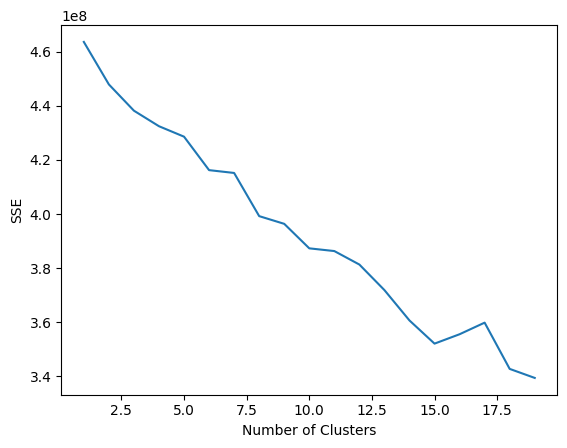

In [52]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(deal_data)
    sse.append(kmeans.inertia_)

# 绘制肘部法图形
plt.plot(range(1, 20), sse)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` 

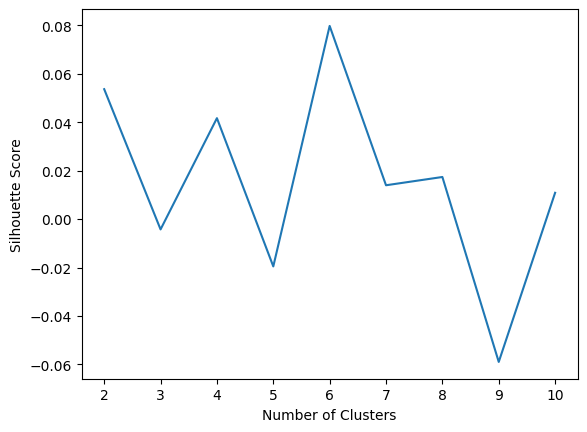

In [55]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(deal_data)
    silhouette_scores.append(silhouette_score(deal_data, kmeans.labels_))

# 绘制轮廓系数图形
plt.plot(range(2, 11), silhouette_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()
